# Modelling the Timbre of a Piano String
Final project for Physics 113 (Stanford University, Computational Physics, Spring 2023, Prof. Tom Abel), by [Alice Ku](mailto:aliceku@stanford.edu) and [Daniel Sun](mailto:dansun@stanford.edu).

[Repository](https://github.com/DanDan0101/PHYSICS-113/tree/main/Final%20Project)

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import scipy

from tqdm.auto import tqdm

In [2]:
# Audio output
SAMPLERATE = 44100
SCALE = np.iinfo(np.int16).max

def export(data, filename, plot = False):
    """Saves a .wav file out of time-series data, sampled at 44.1 kHz.

    Keyword arguments:
    data -- Time-series data
    filename -- Name of the file to save
    plot -- Whether to plot the data (default False)
    """
    # Normalize data
    data_norm = data / np.max(np.abs(data)) * SCALE
    scipy.io.wavfile.write(filename + ".wav", SAMPLERATE, data_norm.astype(np.int16))
    if plot:
        t = np.linspace(0, len(data) / SAMPLERATE, len(data))
        plt.plot(t, data_norm)
        plt.ylabel("Amplitude")
        plt.xlabel("Time [s]")
        plt.title("Sound wave")
        plt.show()

In [3]:
# Plotting output
def anim(u_full, xrange = (0, 1), L = 1):
    """Creates an animation of the wave propagation.

    Keyword arguments:
    u_full -- X, T meshgrid of the wave propagation [m]
    xrange -- Range of the x-axis to plot [m] (default (0, 1))
    L -- Length of the string [m] (default 1)
    """
    # Crop input
    idx = (int(xrange[0] * u_full.shape[0] / L), int(xrange[1] * u_full.shape[0] / L))
    u = u_full[:, idx[0]:idx[1]]
    x = np.linspace(*xrange, u.shape[0])

    # Initialize plot
    fig, ax = plt.subplots()
    line = ax.plot(x, u[:, 0])[0]
    ax.set(xlim = xrange, ylim = (np.min(u), np.max(u)), xlabel = 'Position [m]', ylabel = 'Amplitude')
    plt.close()

    def update(frame):
        line.set_ydata(u[:, frame])
        return line,
    ani = animation.FuncAnimation(fig, update, frames = u.shape[1], interval = 20, blit = True)
    return ani

## Wave Equation
Consider a string of length $L$, pinned at both ends, with linear density $\mu$, wave speed $c=\sqrt{\frac{T}{\mu}}$, cross-sectional area $S$, Young's modulus $E$, and radius of gyration $K=\frac{R}{2}$. Unlike an ideal string, a real string has a resistance against bending, which introduces a fourth-order term into the wave equation:
$$\frac{\partial^2u}{\partial t^2}=c^2\frac{\partial^2u}{\partial x^2}-\frac{ESK^2}{\rho}\frac{\partial^4u}{\partial x^4}$$
$S$ is the cross-sectional area of the string, $E$ is the Young's modulus of its material, $\rho$ is its linear density, and $K$ is the radius of gyration, which is $K=\frac{R}{2}$ for a cylindrical shape of radius $R$. The boundary conditions are:
$$u(0,t)=u(L,t)=0=\frac{\partial^2u}{\partial x^2}(0,t)=\frac{\partial^2u}{\partial x^2}(L,t)$$
Define the following constants:
$$B=\pi^2\frac{ESK^2}{TL^2}=\frac{\pi^3}{4}\frac{ER^4}{TL^2}\sim10^{-3}$$
$$\omega_0=\frac{\pi c}{L}\sqrt{1+B}$$
Then, the solution has frequencies:
$$\omega_n=n\omega_0\sqrt{\frac{1+Bn^2}{1+B}}$$
The solution is then:
$$u(x,t)=\sum_{n=1}^\infty\left[a_n\cos(\omega_n t)+b_n\sin(\omega_n t)\right]\sin\left(\frac{n\pi}{L}x\right)$$

In [4]:
def omega_n(n, f_0, B = 0.001):
    """Returns the angular frequency of the nth harmonic.
    
    Keyword arguments:
    n -- Harmonic number
    f_0 -- Fundamental frequency [Hz]
    B -- Inharmonicity coefficient (default 0.001)
    """
    return 2 * np.pi * n * f_0 * np.sqrt(1 + B * n**2) / np.sqrt(1 + B)

### Infinitely sharp impulse
We treat a hammered string as an instantaneous impulse at some location $x_0\in(0,L)$ on a flat string that gives it velocity $v$, so that:
$$u(x,0)=0$$
$$\frac{\partial u}{\partial t}(x,0)=vL\delta(x_0)$$
By considering the Fourier series of the delta function, we have that:
$$u(x,t)=\sum_{n=1}^\infty\frac{2v}{\omega_n}\sin\left(\frac{n\pi}{L}x_0\right)\sin\left(\frac{n\pi}{L}x\right)\sin(\omega_nt)$$
We'll add an exponential fading term, with characteristic time $\tau\sim1\,\mathrm{s}$:
$$u(x,t)=\sum_{n=1}^\infty\frac{2v}{\omega_n}\sin\left(\frac{n\pi}{L}x_0\right)\sin\left(\frac{n\pi}{L}x\right)\sin(\omega_nt)e^{-\frac{nt}{\tau}}$$

In [5]:
def b_n(n, f_0, x_0, L = 1, B = 0.001, v = 1):
    """Returns the coefficient of the nth harmonic.
    
    Keyword arguments:
    n -- Harmonic number
    f_0 -- Fundamental frequency [Hz]
    x_0 -- Position of the impulse [m]
    L -- Length of the string [m] (default 1)
    B -- Inharmonicity coefficient (default 0.001)
    v -- Strength of the impulse [m/s] (default 1)
    """
    return 2 * v * np.sin(n * np.pi * x_0 / L) / omega_n(n, f_0, B = B)

In [6]:
def u(t, x_0, f_0 = 440, L = 1, B = 1e-3, tau = 1, N = 100, dx = 1e-3, dt = 1e-4):
    """Returns a X, T meshgrid of the wave propagation.

    Keyword arguments:
    t -- Total time [s]
    x_0 -- Position of the impulse [m]
    f_0 -- Fundamental frequency [Hz] (default 440)
    L -- Length of the string [m] (default 1)
    B -- Inharmonicity coefficient (default 0.001)
    tau -- Damping time [s] (default 1)
    N -- Number of harmonics to sum (default 100)
    dx -- Spatial resolution [m] (default 1e-3)
    dt -- Temporal resolution [s] (default 1e-4)
    """
    x_arr = np.arange(0, L, dx)
    t_arr = np.arange(0, t, dt)
    X, T = np.meshgrid(x_arr, t_arr, indexing = 'ij')
    rv = np.zeros_like(X)
    for n in tqdm(range(1, N + 1)):
        omega = omega_n(n, f_0, B = B)
        b = b_n(n, f_0, x_0, L = L, B = B)
        rv += b * np.sin(omega * T) * np.exp(-n * T / tau) * np.sin(n * np.pi / L * X)
    return rv

In [7]:
def sound(t, x_0, f_0 = 440, L = 1, B = 1e-3, tau = 1, N = 100, dt = 1 / SAMPLERATE):
    """Returns a soundwave of the wave propagation.

    Keyword arguments:
    t -- Total time [s]
    x_0 -- Position of the impulse [m]
    f_0 -- Fundamental frequency [Hz] (default 440)
    L -- Length of the string [m] (default 1)
    B -- Inharmonicity coefficient (default 0.001)
    tau -- Damping time [s] (default 1)
    N -- Number of harmonics to sum (default 100)
    dt -- Temporal resolution [s] (default 1 / SAMPLERATE)
    """
    t_arr = np.arange(0, t, dt)
    rv = np.zeros_like(t_arr)
    for n in tqdm(range(1, N + 1)):
        omega = omega_n(n, f_0, B = B)
        b = b_n(n, f_0, x_0, L = L, B = B)
        rv += b * np.sin(omega * t_arr) * np.exp(-n * t_arr / tau)
    return rv

  0%|          | 0/100 [00:00<?, ?it/s]

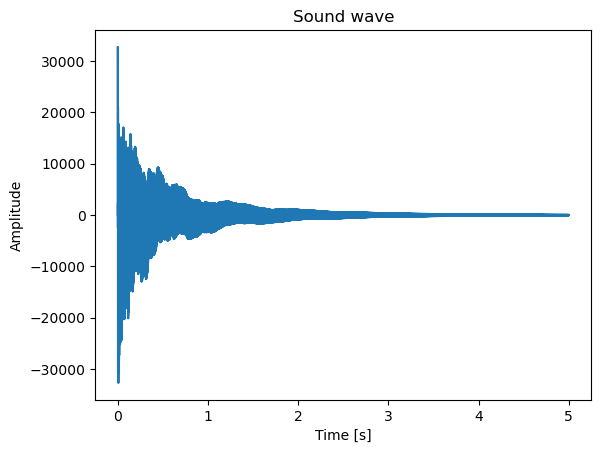

In [8]:
data = sound(5, 0.1, B = 1e-3)
export(data, "test", plot = True)

In [9]:
HTML(anim(u(1e-2, 0.1, B = 1e-3)).to_jshtml())

  0%|          | 0/100 [00:00<?, ?it/s]

## References
[[1603.05516] The wave equation for stiff strings and piano tuning](https://arxiv.org/abs/1603.05516)

[Making Music with Math: A Guide to Synthesizing Sounds with the Wave Equation](https://aatishb.com/stringmath/)